In [1]:
import os
import itertools as it

from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings


from IPython.display import display

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "camera_seconds_since_nuc"

**NOTE**: See the profiled `camera_seconds_since_nuc` [here](https://storage.googleapis.com/anduril-case-study/metrics/camera_seconds_since_nuc.html).

In [2]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.{METRIC}",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  61547 non-null  float64
 1   tower_B  21201 non-null  float64
 2   tower_C  20601 non-null  float64
 3   tower_D  21286 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [4]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,61547.000000,21201.000000,20601.000000,21286.000000
mean,62067.992394,17356.320661,85256.878285,33906.497505
std,87224.987914,23380.658101,108557.632506,49871.508051
min,-4.000000,-4.000000,1.000000,-4.000000
25%,8122.000000,1437.000000,11776.000000,5209.821429
50%,20953.000000,8249.444444,29568.500000,17332.777778
75%,72904.750000,24610.888889,139400.500000,34908.187500
max,363628.500000,155515.375000,425962.000000,269819.666667


In [21]:
df[(df < 0).any(axis=1)]

,tower_A,tower_B,tower_C,tower_D
ts,,,,
2024-01-30 19:23:00+00:00,-4.0,NaN,NaN,NaN
2024-02-08 01:26:00+00:00,358258.0,173.000000,13761.333333,-4.000000
2024-02-08 21:38:00+00:00,5694.0,-4.000000,NaN,2362.666667
2024-02-13 09:02:00+00:00,-4.0,25628.555556,3246.571429,40071.000000


In [5]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)

In [6]:
(df.shift(-1) - df).describe()

,tower_A,tower_B,tower_C,tower_D
count,61494.000000,0.0,0.0,0.0
mean,0.461224,NaN,NaN,NaN
std,1488.865061,NaN,NaN,NaN
min,-242420.833333,NaN,NaN,NaN
25%,26.041667,NaN,NaN,NaN
50%,30.000000,NaN,NaN,NaN
75%,34.500000,NaN,NaN,NaN
max,7456.500000,NaN,NaN,NaN


In [7]:
ex_tower_A, result = [tower for tower in TOWERS if tower != 'tower_A'], []
for tower in ex_tower_A:
    comparison = pd.DataFrame([df['tower_B'].rename('T'), df['tower_B'].shift(1).rename('T+1')]).transpose()
    result.append(comparison[comparison["T"].notnull() & comparison["T+1"].notnull()].empty)

print(list(zip(ex_tower_A, result)))

[('tower_B', True), ('tower_C', True), ('tower_D', True)]


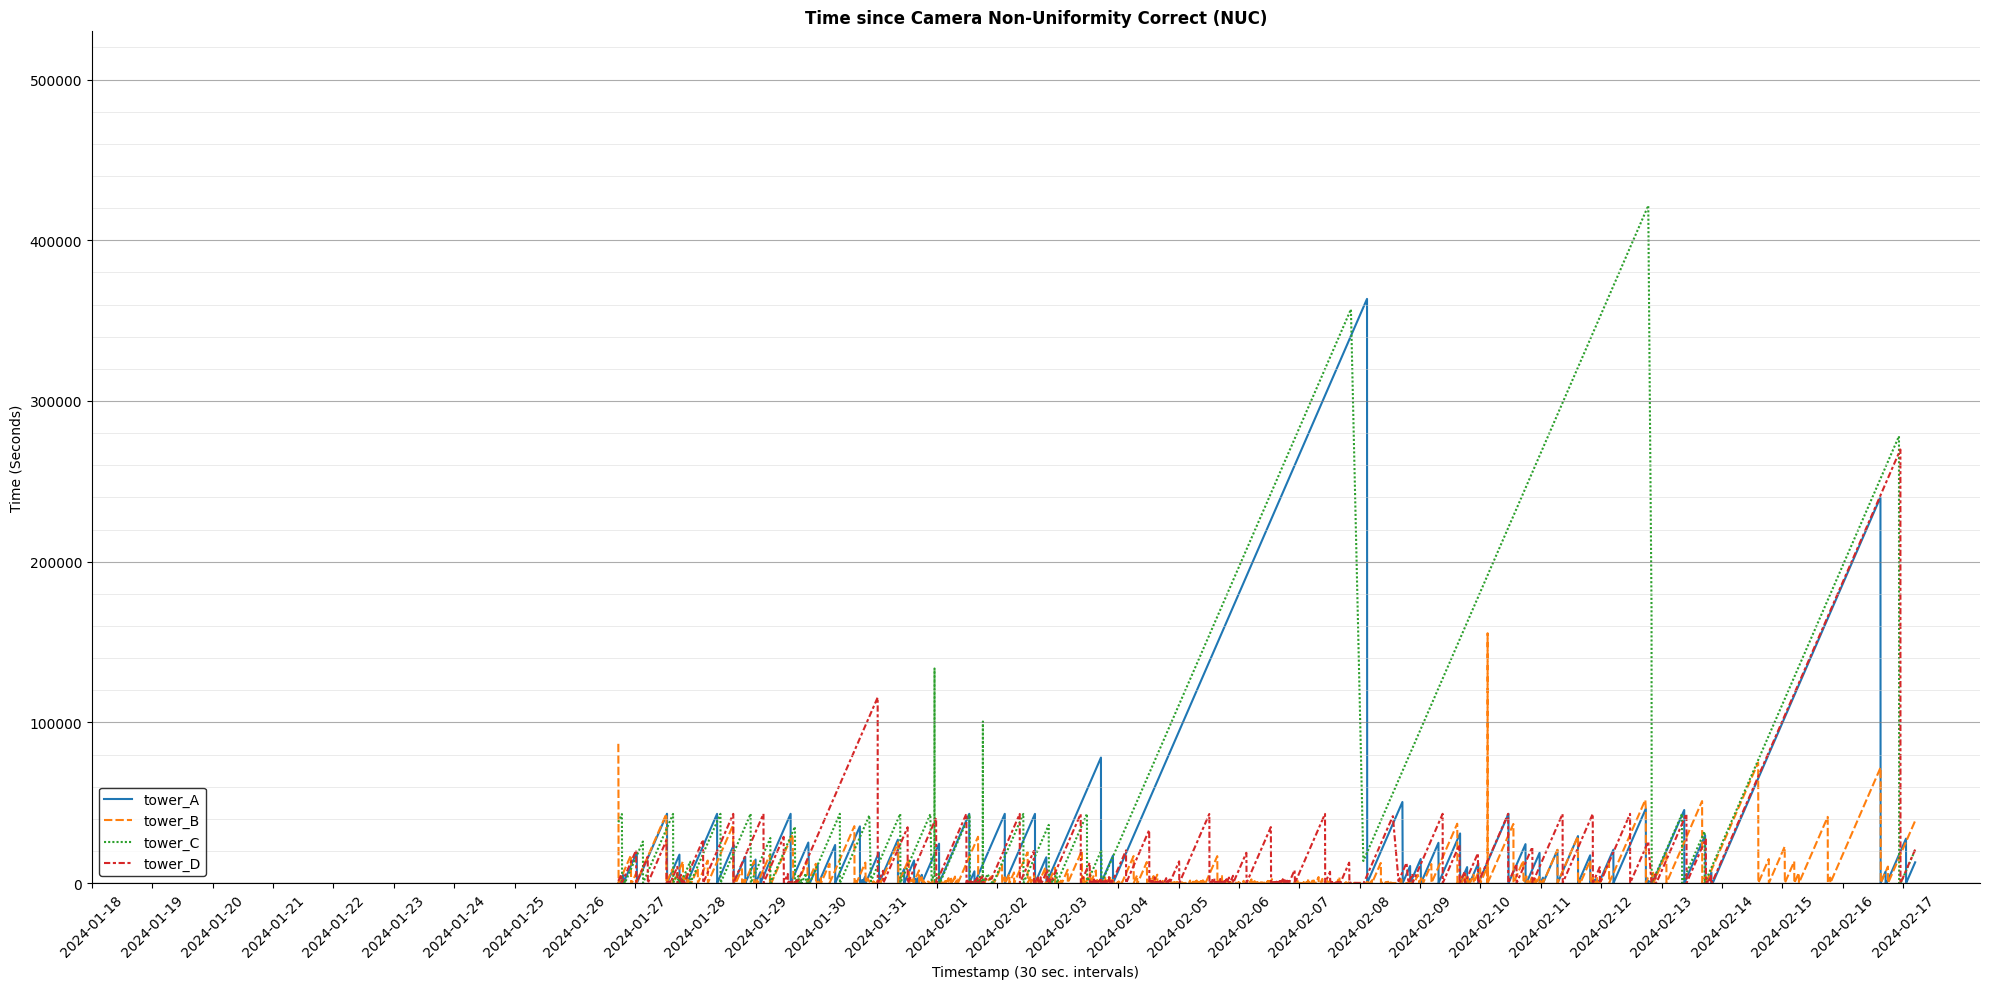

In [8]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(df.dropna())

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('Time since Camera Non-Uniformity Correct (NUC)', weight='bold')
plt.xlabel('Timestamp (30 sec. intervals)')
plt.ylabel('Time (Seconds)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [9]:
df.resample('1d').agg(['mean', 'sem'])

tower_A                    tower_B  \
                                    mean          sem          mean   
ts                                                                    
2024-01-18 00:00:00+00:00            NaN          NaN  13645.603857   
2024-01-19 00:00:00+00:00            NaN          NaN  20085.406390   
2024-01-20 00:00:00+00:00            NaN          NaN  24915.754240   
2024-01-21 00:00:00+00:00            NaN          NaN  98888.343108   
2024-01-22 00:00:00+00:00            NaN          NaN  20249.226322   
2024-01-23 00:00:00+00:00            NaN          NaN  13487.656970   
2024-01-24 00:00:00+00:00            NaN          NaN  14283.345948   
2024-01-25 00:00:00+00:00            NaN          NaN  30917.927110   
2024-01-26 00:00:00+00:00    6667.810859   180.014887  42162.048424   
2024-01-27 00:00:00+00:00   14308.432905   224.956714  12874.429369   
2024-01-28 00:00:00+00:00   16027.000347   211.444045  10801.372131   
2024-01-29 00:00:00+00:00   15523.275249   222.790958   9519.223118   
2024-01-30 00:00:00+00:00   12383.443402   175.303221   9459.186521   
2024-01-31 00:00:00+00:00    9545.608504   134.140101   5846.862209   
2024-02-01 00:00:00+00:00   18083.215229   219.660603   5769.263975   
2024-02-02 00:00:00+00:00   18518.109433   249.023289   4886.017764   
2024-02-03 00:00:00+00:00   35850.766377   442.490548   3933.379829   
2024-02-04 00:00:00+00:00   50687.483507   464.846174   3303.761648   
2024-02-05 00:00:00+00:00  137160.277507   465.157541   2024.292964   
2024-02-06 00:00:00+00:00  223480.477341   465.465945    364.983449   
2024-02-07 00:00:00+00:00  309887.133785   465.036639    464.461194   
2024-02-08 00:00:00+00:00   62490.571069  2266.353101   1588.682607   
2024-02-09 00:00:00+00:00   11007.231308   155.731684   9957.618869   
2024-02-10 00:00:00+00:00   16267.019914   211.144391  10356.036818   
2024-02-11 00:00:00+00:00    9524.836983   147.113685   8949.982963   
2024-02-12 00:00:00+00:00   16126.577083   243.855644  18146.167858   
2024-02-13 00:00:00+00:00   17573.504860   238.437778  19616.209303   
2024-02-14 00:00:00+00:00   56478.012803   465.075335  33038.043186   
2024-02-15 00:00:00+00:00  142532.865421   468.914935  13983.439202   
2024-02-16 00:00:00+00:00  137040.140616  1852.942866  31579.228707   
2024-02-17 00:00:00+00:00   11275.357308   372.286427  48840.943119   

                                             tower_C               \
                                  sem           mean          sem   
ts                                                                  
2024-01-18 00:00:00+00:00  466.094832   18986.235526  1680.737746   
2024-01-19 00:00:00+00:00  486.916734   21613.934132   464.345472   
2024-01-20 00:00:00+00:00  569.950813   14870.464068   460.439259   
2024-01-21 00:00:00+00:00  992.410402   13183.283540   464.440655   
2024-01-22 00:00:00+00:00  460.063738   16055.261363   484.611306   
2024-01-23 00:00:00+00:00  587.110371   15503.098168   423.247002   
2024-01-24 00:00:00+00:00  447.699765   21613.544892   464.176656   
2024-01-25 00:00:00+00:00  734.239405   19163.673789   418.950180   
2024-01-26 00:00:00+00:00  998.325511   20849.495955   490.055943   
2024-01-27 00:00:00+00:00  471.052997   15102.305027   456.448478   
2024-01-28 00:00:00+00:00  361.858084   21521.605028   461.251390   
2024-01-29 00:00:00+00:00  297.940411   12812.652346   383.197985   
2024-01-30 00:00:00+00:00  373.461173   20474.862849   476.283916   
2024-01-31 00:00:00+00:00  252.585168   20831.147678   521.326359   
2024-02-01 00:00:00+00:00  295.841163   13732.385821   569.362392   
2024-02-02 00:00:00+00:00  168.483855   18537.911281   459.890988   
2024-02-03 00:00:00+00:00  180.135874   16597.350267   413.826148   
2024-02-04 00:00:00+00:00  160.349325   67183.552770   930.121549   
2024-02-05 00:00:00+00:00  144.843031  152682.220285   947.836658   
2024-02-06 00:00:00+00:00   19.611293  237613.239196   967.806190   
2024-02-07 00:00:00+00:00   27.

## Critical Points

We can query for critical points by looking for non-increasing sequences.

In [10]:
increasing_dfs, non_increasing_dfs = {}, {}
for tower in TOWERS:
    tower_nonnull = df[tower].dropna()
    is_increasing = (tower_nonnull.shift(1) < tower_nonnull) & (tower_nonnull < tower_nonnull.shift(-1))
    increasing_points, non_increasing_points = tower_nonnull[is_increasing], tower_nonnull[~is_increasing]
    increasing_dfs[tower]= increasing_points
    non_increasing_dfs[tower] = non_increasing_points

In [11]:
for tower in TOWERS:
    for i in non_increasing_dfs[tower].index:
        low = non_increasing_dfs[tower].index.get_loc(i) - 5
        high = non_increasing_dfs[tower].index.get_loc(i) + 5
        rows = non_increasing_dfs[tower].iloc[low:high]
        print(rows)

Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
Series([], Name: tower_A, dtype: float64)
ts
2024-01-26 17:16:00+00:00       6.500000
2024-01-26 17:21:30+00:00     284.857143
2024-01-26 17:22:00+00:00     201.384615
2024-01-26 17:22:30+00:00      15.000000
2024-01-26 17:24:30+00:00     136.000000
2024-01-26 17:26:30+00:00      49.000000
2024-01-26 17:42:30+00:00     961.000000
2024-01-26 17:43:00+00:00     498.500000
2024-01-26 17:43:30+00:00      35.500000
2024-01-26 19:15:30+00:00    5556.000000
Name: tower_A, dtype: float64
ts
2024-01-26 17:21:30+00:00     284.857143
2024-01-26 17:22:00+00:00     201.384615
2024-01-26 17:22:30+00:00      15.000000
2024-01-26 17:24:30+00:00     136.000000
2024-01-26 17:26:30+00:00      49.000000
2024-01-26 17:42:30+00:00     961.000000
2024-01-26 17:43:00+00:00     498.500000
2024-01-26 17:43:30+00:00      35.500000
2024-01-26 19:15

We can further isolate peaks, to do a peak-to-peak comparison.

In [12]:
peaks = {}
for tower, ni_df in non_increasing_dfs.items():
    ni_df = ni_df.to_frame()
    ni_df['prev_value'] = ni_df[tower].shift(1)
    ni_df['next_value'] = ni_df[tower].shift(-1)
    ni_df['is_peak'] = (ni_df[tower] > ni_df['prev_value']) & (ni_df[tower] > ni_df['next_value'])
    peaks_ni_df = ni_df[ni_df['is_peak']]
    peaks[tower] = peaks_ni_df
    display(peaks[tower])

,tower_A,prev_value,next_value,is_peak
ts,,,,
2024-01-26 17:21:30+00:00,284.857143,6.5,201.384615,True
2024-01-26 17:24:30+00:00,136.000000,15.0,49.000000,True
2024-01-26 17:42:30+00:00,961.000000,49.0,498.500000,True
2024-01-26 19:15:30+00:00,5556.000000,35.5,1861.000000,True
2024-01-27 00:37:30+00:00,19288.500000,36.0,6440.333333,True
...,...,...,...,...
2024-02-16 15:01:30+00:00,240187.000000,31.0,120107.000000,True
2024-02-16 17:02:30+00:00,7226.000000,36.0,21.000000,True
2024-02-16 17:24:30+00:00,1314.000000,21.0,11.000000,True


,tower_B,prev_value,next_value,is_peak
ts,,,,
2024-01-18 20:10:00+00:00,27683.000000,9798.555556,23813.714286,True
2024-01-19 08:30:00+00:00,44236.000000,64.000000,13318.000000,True
2024-01-19 19:36:00+00:00,39846.727273,135.333333,14537.545455,True
2024-01-19 20:56:00+00:00,4676.750000,126.600000,15.400000,True
2024-01-19 23:08:00+00:00,7789.583333,15.400000,1609.700000,True
...,...,...,...,...
2024-02-15 06:32:00+00:00,6412.250000,48.222222,3255.375000,True
2024-02-15 18:02:00+00:00,41249.666667,99.000000,8297.300000,True
2024-02-15 19:02:00+00:00,3516.000000,153.400000,1211.888889,True


,tower_C,prev_value,next_value,is_peak
ts,,,,
2024-01-18 20:12:00+00:00,36936.666667,34763.235294,36611.898361,True
2024-01-18 21:50:00+00:00,42857.000000,36129.995902,103.500000,True
2024-01-19 09:56:00+00:00,43140.750000,103.500000,4361.600000,True
2024-01-19 21:56:00+00:00,43128.111111,158.714286,7889.363636,True
2024-01-20 09:56:00+00:00,43111.000000,149.500000,14418.888889,True
...,...,...,...,...
2024-02-17 18:40:00+00:00,632.000000,157.200000,493.333333,True
2024-02-17 18:46:00+00:00,196.454545,88.777778,61.000000,True
2024-02-17 18:56:00+00:00,553.000000,61.000000,53.500000,True


,tower_D,prev_value,next_value,is_peak
ts,,,,
2024-01-19 03:46:00+00:00,43063.454545,16185.250000,31395.181818,True
2024-01-19 15:48:00+00:00,43162.750000,82.000000,66.000000,True
2024-01-20 03:48:00+00:00,43148.000000,66.000000,3978.181818,True
2024-01-20 13:16:00+00:00,34022.428571,168.400000,8547.250000,True
2024-01-20 14:22:00+00:00,3864.000000,134.727273,3579.900000,True
...,...,...,...,...
2024-02-17 17:38:00+00:00,3198.727273,91.000000,2953.888889,True
2024-02-17 17:48:00+00:00,433.000000,65.444444,146.777778,True
2024-02-17 18:02:00+00:00,748.000000,143.555556,356.800000,True


In [13]:
peak_to_peak_times = pd.DataFrame([peaks[tower].index.diff().to_list() for tower in TOWERS]).drop(0, axis=1).transpose()
peak_to_peak_times.columns = TOWERS

peak_to_peak_times

,tower_A,tower_B,tower_C,tower_D
1,0 days 00:03:00,0 days 12:20:00,0 days 01:38:00,0 days 12:02:00
2,0 days 00:18:00,0 days 11:06:00,0 days 12:06:00,0 days 12:00:00
3,0 days 01:33:00,0 days 01:20:00,0 days 12:00:00,0 days 09:28:00
4,0 days 05:22:00,0 days 02:12:00,0 days 12:00:00,0 days 01:06:00
5,0 days 12:00:30,0 days 08:52:00,0 days 07:00:00,0 days 00:08:00
...,...,...,...,...
1024,NaT,0 days 01:48:00,NaT,NaT
1025,NaT,0 days 11:30:00,NaT,NaT
1026,NaT,0 days 01:00:00,NaT,NaT
1027,NaT,0 days 20:02:00,NaT,NaT


In [14]:
peak_to_peak_times.mean()

tower_A   0 days 05:26:42.127659574
tower_B   0 days 00:40:29.649805447
tower_C      0 days 05:37:02.812500
tower_D   0 days 02:07:46.347305389
dtype: timedelta64[ns]